Using hypothetical radiation curves based on lat/lon and time of year to try to mach par data (shape) from popup buoy

- from a quick literature search, 4.6 umole*m^-2*s^-1 is rougly 1 w/m^2   
- https://www.researchgate.net/post/Can_I_convert_PAR_photo_active_radiation_value_of_micro_mole_M2_S_to_Solar_radiation_in_Watt_m22

In [310]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean

In [311]:
server_url = 'http://akutan.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

df = pd.read_csv(e.get_search_url(response='csv', search_for='POPUP'))

In [312]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 12 tabledap, 0 griddap, and 0 wms endpoints.'

In [313]:
popups = df['Dataset ID'].values
print(popups)

['2019_PopUP_300434063823800_bottom_data'
 '2019_PopUP_300434063823800_sst_data'
 '2019_PopUP_300434063823800_underice_data'
 '2019_PopUP_300434063921240_bottom_data'
 '2019_PopUP_300434063921240_sst_data'
 '2019_PopUP_300434063921240_underice_data'
 '2019_PopUP_300434063925210_bottom_data'
 '2019_PopUP_300434063925210_sst_data'
 '2019_PopUP_300434063925210_underice_data'
 '2019_PopUP_300434063928220_bottom_data'
 '2019_PopUP_300434063928220_sst_data'
 '2019_PopUP_300434063928220_underice_data']


In [314]:
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
          )

d.dataset_id='2019_PopUP_300434063928220_sst_data'

d.variables =  [
 'timeseries_id',
 'par',
 'topside_temp',
 'underside_temp',
 'fluor',
 'pressure',
 "time"
]

d.constraints = {
    'time>=': '2019-01-01T00:00:00Z',
    'time<=': '2019-10-10T00:00:00Z',
}

In [315]:
df = d.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.head()

,timeseries_id,par,topside_temp (degree_C),underside_temp (degree_C),fluor,pressure
time (UTC),,,,,,
2019-02-24 20:40:25+00:00,3.004341e+14,1.140616,-1.849989,-1.686450,0.0,0.010681
2019-02-24 21:00:35+00:00,3.004341e+14,0.448767,-1.843747,-1.683877,0.0,0.010681
2019-02-24 21:20:45+00:00,3.004341e+14,0.149589,-1.856227,-1.686450,0.0,0.011292
2019-02-24 21:40:55+00:00,3.004341e+14,0.056096,-1.787468,-1.683877,0.0,0.011902
2019-02-24 22:01:05+00:00,3.004341e+14,0.056096,-1.761138,-1.681946,0.0,0.012207


In [316]:
#corrections, offsets and conversions
# https://www.controlledenvironments.org/wp-content/uploads/sites/6/2017/06/Ch01.pdf
# http://www.egc.com/useful_info_lighting.php
# par to w/m2 is ~ par/4.6 or wm2*4.6 but this is for the 400-700nm band, irradiance is usually global
#  and at the equator is roughly 45% of this value (so wm2*0.45*4.6) or more specifically use values from
#  Britton and Dodd 1976 of 2.08-2.6 depending on time of year and day characteristics

# par for this instrument is umol/(m2*s) -> uEin/(m2*s)
df.par = df.par/2.2
df.index=df.index+datetime.timedelta(hours=7)

In [317]:
cdate = datetime.datetime(2019, 6, 15, 0, tzinfo=datetime.timezone.utc)

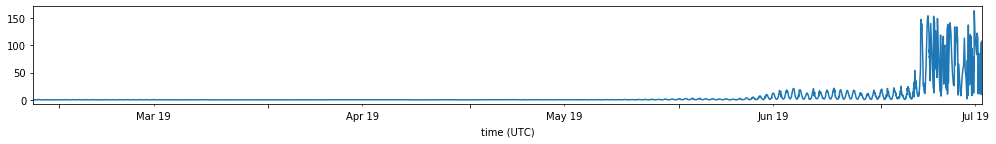

In [318]:
fig, ax = plt.subplots(figsize=(17, 2))
df.par.plot()
ax.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(DateFormatter('%b %y'))
ax.xaxis.set_major_formatter(DateFormatter(''))
ax.xaxis.set_tick_params(which='major', pad=15)
ax.xaxis.set_tick_params(which='minor', pad=5)


(0, 100)

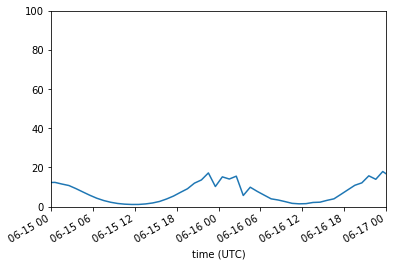

In [323]:
# fig, ax = plt.subplots(figsize=(17, 2))
df.par.plot()
ax.xaxis.set_major_locator(HourLocator([0,6,12,18]))
ax.xaxis.set_minor_locator(HourLocator(range(0,24)))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(DateFormatter('%H:%M'))
ax.xaxis.set_major_formatter(DateFormatter('%H'))
ax.xaxis.set_tick_params(which='major', pad=15)
ax.xaxis.set_tick_params(which='minor', pad=5)
plt.xlim([cdate,cdate+datetime.timedelta(days=2)])
plt.ylim([0,100])

### based on location grid, calculate theoretical solar curves

In [320]:
from pysolar.solar import *
import datetime

### example below
from dateutil import tz

lat = np.arange(65,78,2)
lon = np.arange(-167,-184,-2)

all_solar = {}

for l in lat:
    for j in lon:
        name = str(l)+'_'+str(j)
        solar_hypothetical = pd.DataFrame(columns=('Datetime', 'deg', 'rad','irr'))

        for i in range(48):

            date = cdate + datetime.timedelta(hours=i - 1)
            altitude_deg = get_altitude(l,j, date)
            #altitude_deg = get_altitude(73.93197,177.27985, date)
            rad = radiation.get_radiation_direct(date, altitude_deg)
            irr = rad*np.cos(np.deg2rad(90-altitude_deg))
            solar_hypothetical.loc[i] = [date,altitude_deg,rad,irr]

        solar_hypothetical = solar_hypothetical.set_index('Datetime')


        solar_hypothetical['sza'] = np.nan
        
        all_solar.update({name:solar_hypothetical})

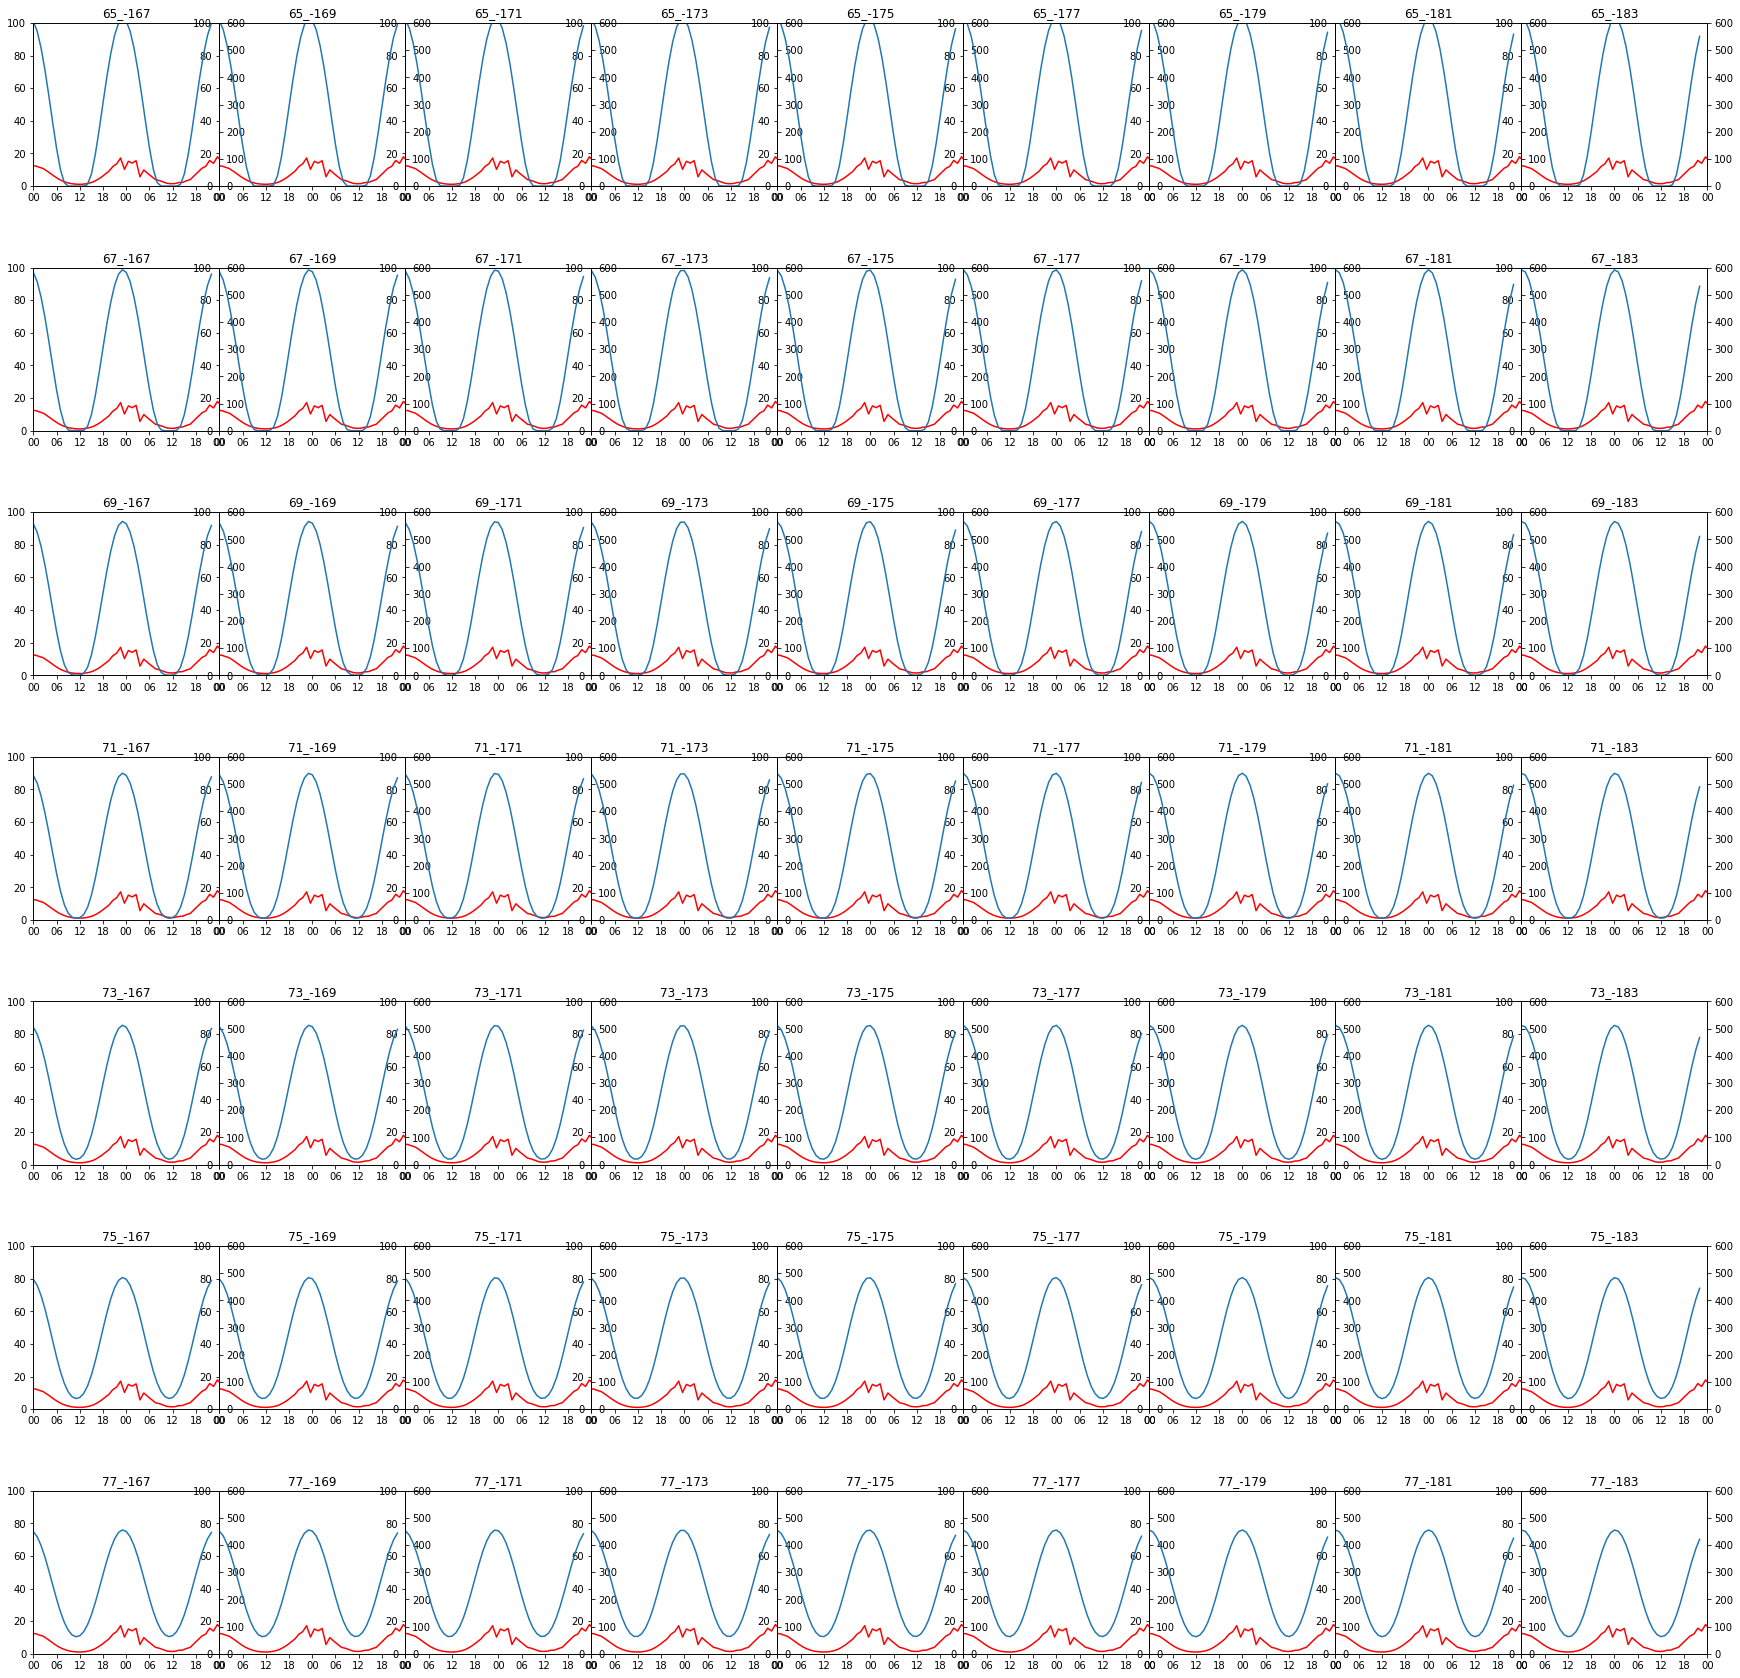

In [324]:
fig, axs = plt.subplots(7,9, figsize=(30, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i,v in enumerate(all_solar):

    axs[i].plot(df.index,df.par,'r')
    axp = axs[i].twinx()
    axp.plot(all_solar[v]['irr'])
    axs[i].xaxis.set_major_locator(HourLocator([0,6,12,18]))

    axs[i].xaxis.set_major_formatter(DateFormatter('%H'))
    axp.xaxis.set_major_formatter(DateFormatter('%H'))

    axs[i].set_xlim([cdate,cdate+datetime.timedelta(days=2)])
    axs[i].set_ylim([0,100])
    axp.set_ylim([0,600])
    axs[i].set_title(v)


In [322]:
fig.savefig('solar_'+(cdate+datetime.timedelta(days=1)).strftime('%Y%m%d')+'.png',dpi=300)